<a href="https://colab.research.google.com/github/EVA6-Group-15/discover-architectures/blob/master/MNIST_99_4_Iteration_01.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
%load_ext autoreload
%autoreload 2

In [ ]:
!git clone https://github.com/EVA6-Group-15/DLUtils.git dlutils

Cloning into 'dlutils'...
remote: Enumerating objects: 13, done.
remote: Counting objects: 100% (13/13), done.
remote: Compressing objects: 100% (12/12), done.
remote: Total 13 (delta 2), reused 0 (delta 0), pack-reused 0
Unpacking objects: 100% (13/13), done.


# Memory Information and GPU Information



In [ ]:
import psutil
def get_size(bytes, suffix="B"):
    factor = 1024
    for unit in ["", "K", "M", "G", "T", "P"]:
        if bytes < factor:
            return f"{bytes:.2f}{unit}{suffix}"
        bytes /= factor
print("="*40, "Memory Information", "="*40)
svmem = psutil.virtual_memory()
print(f"Total: {get_size(svmem.total)}") ; print(f"Available: {get_size(svmem.available)}")
print(f"Used: {get_size(svmem.used)}") ; print(f"Percentage: {svmem.percent}%")

======================================== Memory Information ========================================
Total: 12.69GB
Available: 11.87GB
Used: 552.01MB
Percentage: 6.4%


In [ ]:
! nvidia-smi

Thu Jun  3 16:42:41 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 465.27       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   68C    P8    12W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

# Targets

To create a basic skeleton of the the model

**Parameters**: Less than 10,000  
**Data Augmentations**: None  
**Regularization**: None  
**LR Scheduler**: None  
**No. of Epochs**: 14  


# Imports

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torchsummary import summary
import dlutils.plotter as plotter
import dlutils.train as train
import dlutils.test as test

# Data

In [ ]:
train_data_ = datasets.MNIST('../data', train=True, download=True,
                    transform=transforms.Compose([
                        transforms.ToTensor()]))


Extracting ../data/MNIST/raw/train-images-idx3-ubyte.gz to ../data/MNIST/raw




Extracting ../data/MNIST/raw/train-labels-idx1-ubyte.gz to ../data/MNIST/raw




Extracting ../data/MNIST/raw/t10k-images-idx3-ubyte.gz to ../data/MNIST/raw




Extracting ../data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ../data/MNIST/raw

Processing...
Done!


/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:502: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:143.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


In [ ]:
plotter.data_stats(train_data_)

Train Statistics
 - Numpy Shape: (60000, 28, 28)
 - Tensor Shape: torch.Size([60000, 28, 28])
 - min: tensor(0.)
 - max: tensor(1.)
 - mean: tensor(0.1307)
 - std: tensor(0.3081)
 - var: tensor(0.0949)


In [ ]:
torch.manual_seed(1)
batch_size = 64

use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")

kwargs = {'num_workers': 1, 'pin_memory': True} if use_cuda else {}

train_data = datasets.MNIST('../data', train=True, download=True,
                    transform=transforms.Compose([
                        transforms.ToTensor(),
                        transforms.Normalize((0.1307,), (0.3081,))]))
train_loader = torch.utils.data.DataLoader(train_data,batch_size=batch_size,
                                           shuffle=True, **kwargs)

test_data = datasets.MNIST('../data', train=False, transform=transforms.Compose([
                        transforms.ToTensor(),
                        transforms.Normalize((0.1307,), (0.3081,))]))
test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size,
                                          shuffle=True, **kwargs)

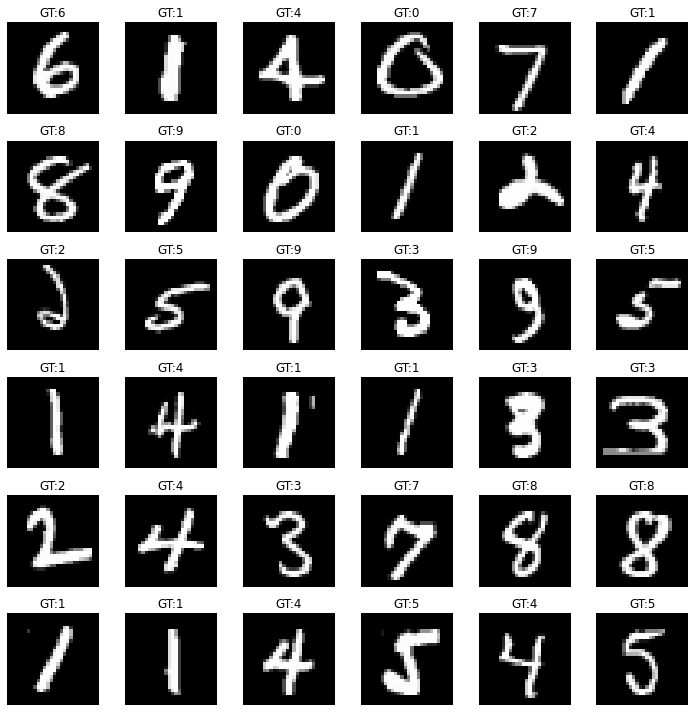

In [ ]:
class_list = [0,1,2,3,4,5,6,7,8,9]
plotter.plot_data_grid(train_loader, mean= (0.1307,), std= (0.3081,), class_list=class_list, ncol=6,nrow=6)

# Model

In [ ]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()

        self.layer1 = nn.Sequential(
            # 28x28x1 -> 26x26x4
            nn.Conv2d(in_channels=1, out_channels=4, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(num_features=4),
            nn.ReLU(),
            # 26x26x4 -> 24x24x8
            nn.Conv2d(in_channels=4, out_channels=8, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(num_features=8),
            nn.ReLU(),
            # 24x24x8 -> 12x12x8
            nn.MaxPool2d(kernel_size=2, stride=2)
        )


        self.layer2 =  nn.Sequential(
            # 12x12x8 -> 10x10x12
            nn.Conv2d(in_channels=8, out_channels=16, kernel_size=3, bias=False),
            nn.BatchNorm2d(num_features=16),
            nn.ReLU(),
            # 10x10x12 -> 8x8x12
            nn.Conv2d(in_channels=16, out_channels=20, kernel_size=3, bias=False),
            nn.BatchNorm2d(num_features=20),
            nn.ReLU(),
            # 8x8x12 -> 6x6x16
            nn.Conv2d(in_channels=20, out_channels=24, kernel_size=3, bias=False)
        )
        
        self.gap = nn.AdaptiveAvgPool2d(1)

        self.classifier = nn.Sequential(  # Similar
            nn.Linear(in_features=24, out_features=32),
            nn.Linear(in_features=32, out_features=10)
        )

    def forward(self, x):
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.gap(x)
        x = x.view(-1,24)
        x = self.classifier(x)

        return F.log_softmax(x, dim=1)

In [ ]:
model = Net().to(device)
summary(model, input_size=(1, 28, 28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 4, 28, 28]              36
       BatchNorm2d-2            [-1, 4, 28, 28]               8
              ReLU-3            [-1, 4, 28, 28]               0
            Conv2d-4            [-1, 8, 28, 28]             288
       BatchNorm2d-5            [-1, 8, 28, 28]              16
              ReLU-6            [-1, 8, 28, 28]               0
         MaxPool2d-7            [-1, 8, 14, 14]               0
            Conv2d-8           [-1, 16, 12, 12]           1,152
       BatchNorm2d-9           [-1, 16, 12, 12]              32
             ReLU-10           [-1, 16, 12, 12]               0
           Conv2d-11           [-1, 20, 10, 10]           2,880
      BatchNorm2d-12           [-1, 20, 10, 10]              40
             ReLU-13           [-1, 20, 10, 10]               0
           Conv2d-14             [-1, 2

# Training

In [ ]:
model = Net().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
trainer = train.Train(model, device, train_loader, optimizer)
tester = test.Test(model, device, test_loader)

for epoch in range(1, 15):
    print(f'Epoch: {epoch}')
    train_loss, train_acc = trainer()
    test_loss, test_acc = tester()

    print('Train: Average loss: {:.4f}, Train Accuracy: {:.2f}%; Test: Average loss: {:.4f}, Test Accuracy: {:.2f}%'.format(train_loss, train_acc, test_loss, test_acc))

  0%|          | 0/938 [00:00<?, ?it/s]

Epoch: 1


loss=0.040242306888103485 batch_id=937: 100%|██████████| 938/938 [00:16<00:00, 57.85it/s]


Train: Average loss: 0.5519, Train Accuracy: 81.12%; Test: Average loss: 0.3573, Test Accuracy: 88.96%
Epoch: 2
Train: Average loss: 0.1186, Train Accuracy: 96.38%; Test: Average loss: 0.0955, Test Accuracy: 96.88%
Epoch: 3
Train: Average loss: 0.0832, Train Accuracy: 97.38%; Test: Average loss: 0.0733, Test Accuracy: 97.76%
Epoch: 4
Train: Average loss: 0.0667, Train Accuracy: 97.92%; Test: Average loss: 0.0486, Test Accuracy: 98.65%
Epoch: 5
Train: Average loss: 0.0589, Train Accuracy: 98.17%; Test: Average loss: 0.0459, Test Accuracy: 98.61%
Epoch: 6
Train: Average loss: 0.0503, Train Accuracy: 98.44%; Test: Average loss: 0.0417, Test Accuracy: 98.63%
Epoch: 7
Train: Average loss: 0.0458, Train Accuracy: 98.56%; Test: Average loss: 0.0367, Test Accuracy: 98.88%
Epoch: 8
Train: Average loss: 0.0424, Train Accuracy: 98.66%; Test: Average loss: 0.0383, Test Accuracy: 98.75%
Epoch: 9
Train: Average loss: 0.0380, Train Accuracy: 98.77%; Test: Average loss: 0.0463, Test Accuracy: 98.64%
E

# Results

In [ ]:
print('Train Accuracy:', max(trainer.accuracy))
print('Test Accuracy:', max(tester.accuracy))

Train Accuracy: 99.14333333333333
Test Accuracy: 99.0


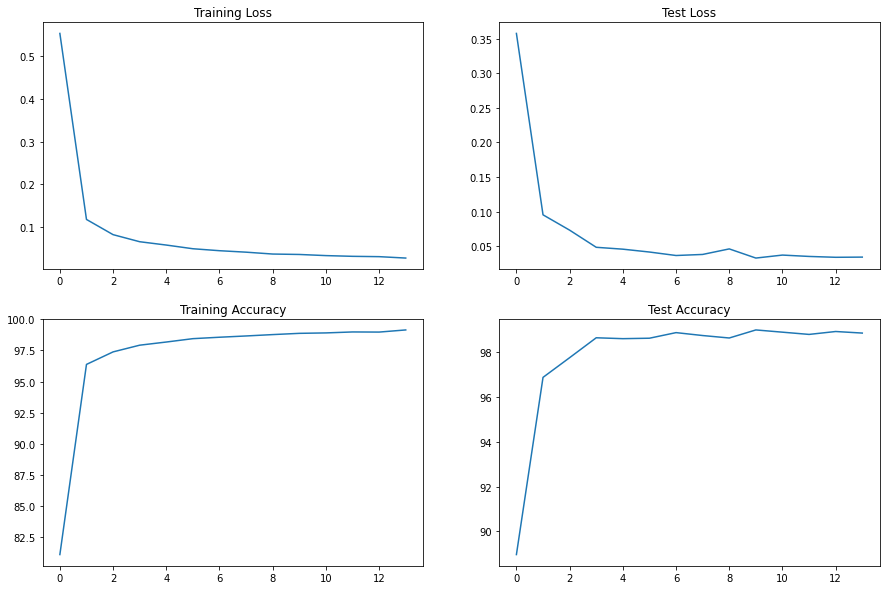

In [ ]:
plotter.plot_loss_acc(trainer.loss, trainer.accuracy, tester.loss, tester.accuracy)

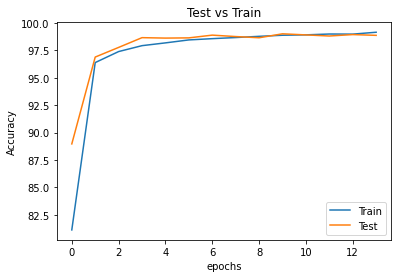

In [ ]:
plotter.plot_combined(trainer.accuracy, tester.accuracy,  x_label='epochs', y_label='Accuracy')

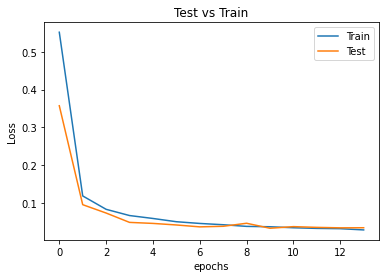

In [ ]:
plotter.plot_combined(trainer.loss, tester.loss,  x_label='epochs', y_label='Loss')

In [ ]:
class_list = [0,1,2,3,4,5,6,7,8,9]
mean= (0.1307,)
std= (0.3081,)
results = plotter.Results(model, test_loader, device, mean, std, class_list)

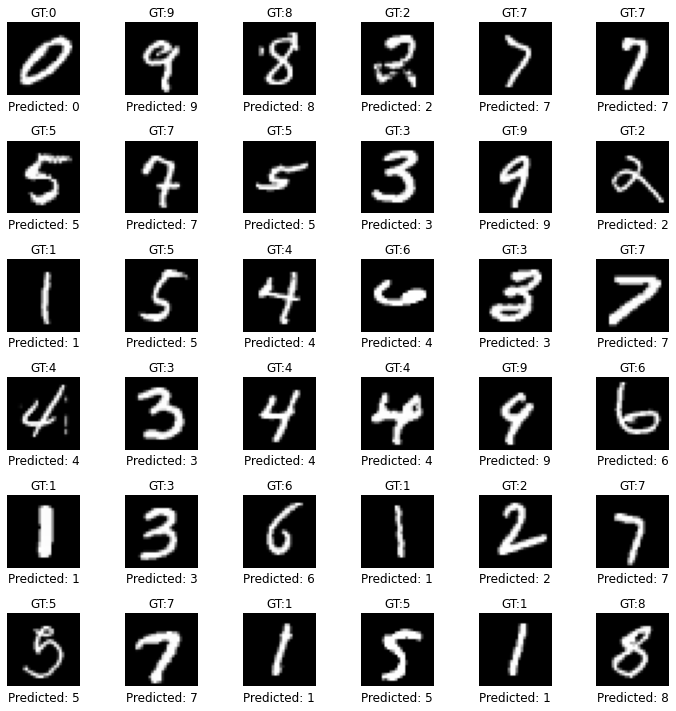

In [ ]:
results.plot_batch(6,6)

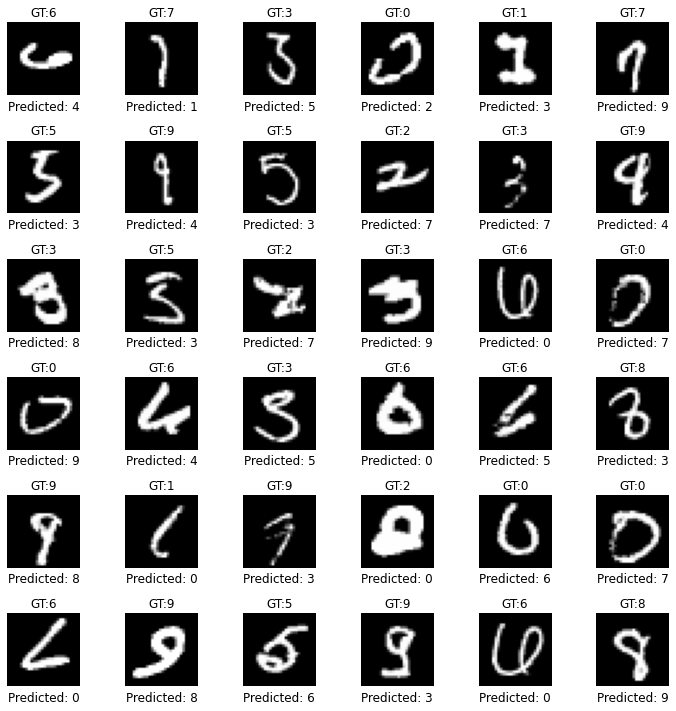

In [ ]:
results.plot_incorrect()

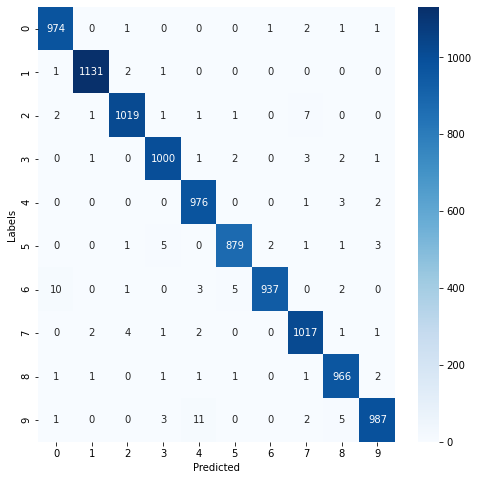

Accuracies of Top 10 Classes in Decreasing Order
Accuracy of class 6 is 97.81
Accuracy of class 9 is 97.82
Accuracy of class 5 is 98.54
Accuracy of class 2 is 98.74
Accuracy of class 7 is 98.93
Accuracy of class 3 is 99.01
Accuracy of class 8 is 99.18
Accuracy of class 0 is 99.39
Accuracy of class 4 is 99.39
Accuracy of class 1 is 99.65


In [ ]:
results.class_accuracy()

# Achievements

- Total Parameters used: **9,902**
- Best Train Accuracy: **99.14%**
- Best Test Accuracy: **99.00%**
- Consistency: Did not achieve any consistency with test accuracy greater than 99.4
- Base network architecture design

# Analysis

With the base network architecture, we achieved a test accuracy of 99% which is not even close to the target test accuracy to achieve. We plan to improve the test accuracy by doing the following approaches:

Split the process into two different networks by varying the number of parameters.
1. Keep the same network architecture, but removing the fully connected layers.
2. Reduce the number of parameters in the model.

In each of these approaches, we performed the following changes in order to assist in achieving the target test accuracy.

- Add Dropout layers
- Perform Data Augmentation
- Use Learning Rate Schedulers